In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii

from scipy import stats, interpolate
from scipy.integrate import quad, cumtrapz
from scipy.optimize import curve_fit

from magnification_library import *
import clmm
from clmm import utils 
import pyccl

In [2]:
#define clmm cosmology
#from https://arxiv.org/pdf/1904.13378.pdf%20for%20u-dropout BEWARE that CT backend can not handle sigma8
cosmo = clmm.Cosmology(H0 = 67.7, Omega_dm0 = 0.311-0.04898, Omega_b0 = 0.04898, Omega_k0 = 0.0) 
#equivalent to cosmo.get_desc()
print ("CLMM backend = ", cosmo.backend)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c = cosmo.be_cosmo.Odm0, Omega_b=cosmo.be_cosmo.Ob0,
                      h=cosmo.be_cosmo.h, sigma8= 0.80, n_s=0.963)

CLMM backend =  ct


In [321]:
#computation utils properties
z_s = np.linspace(0.001, 4, 1000)
zinf = 1e10 

conv = cosmo.be_cosmo.arcsec_per_kpc_proper(z_s) #.to(u.arcmin/u.Mpc)  #.to(u.deg/u.Mpc)

rproj = np.linspace(0.01, 10, 1000)

A = 1.*u.Mpc**2

# **1) Sources properties**

In [322]:
#lens properties 
z_cl = [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5]

## **Sources**

In [323]:
#CONVERSION BETWEEN VALUES IN CHANG ET AL. 2017 
#https://arxiv.org/pdf/1305.0793.pdf

#n, neff = 46, 37 #k=1, r+i, table1 Y10 values from table 1
n, neff = 46/np.sqrt(10),11 #k=1, r+i, Y1 values from table 1 and figure 6
#n, neff = 46/np.sqrt(2),23 #k=1, r+i, Y5 values from table 1 and figure 6

blend_eta, blend_mu = 0.68,5.5*1e-3 #d=2arcsec table 3.

neff_blend = (1-blend_eta*np.log(1+blend_mu*n))*neff
neff_blend_mask = 0.85*neff_blend
print(n,neff, neff_blend, neff_blend_mask)

14.546477236774544 11 10.424292455439407 8.860648587123496


In [390]:
(1+2.5) * 1500, (1+3) * 1500, (1+3.5) * 1500

(5250.0, 6000, 6750.0)

In [391]:
#Source galaxies properties 
#(source shear shot noise or LF slope, source density, redshift distribution parametrization)

#SHEAR LSST__________________________________________________________________
# fiducial number for Y10 (Y1) after blending + masking https://arxiv.org/pdf/1305.0793.pdf
s_e = 0.26
n_e_Y10 = 26 /u.arcmin**2
n_e_Y1 = 9 /u.arcmin**2

def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3)/norm

#MAGNIFICATION LSST u-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout

LF_param = {'z_eff':[2.,3.,3.8,4.9,5.9], 'phi_star':[97.0,50.4,92.5,32.2,16.4]*1/(cosmo.be_cosmo.h*u.Mpc**3), 'alpha':[-1.60,-1.78,-1.57,-1.60,-1.87], 'm_star_UV':[24.2,24.7,25.4,25.5,25.8]}

#At z~3 the LSST band corresponding to UV ~ 1500 Angstrom is the r band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1 = 25.81 #r band
mlimY10 = 27.04 #r band

alpha_lbg_Y1 = 2.5 * slope(mlimY1, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter")
alpha_lbg_Y10 = 2.5 * slope(mlimY10, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter")
n_eff_lbg_Y1 = (1.8e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
n_eff_lbg_Y10 = (7.5*1e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 

def mu_lbg_pdz(z):
    func = gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]


#MAGNIFICATION Euclid/WFIRST Halpha_________________________________________________________
#https://arxiv.org/pdf/1710.00833.pdf
#https://arxiv.org/pdf/1603.01453.pdf
    
    
#MAGNIFICATION DESI QSO_________________________________________________________
alpha_qso =  2.5 *0.196 #for QSO based on last raw of Table 1 in https://www.aanda.org/articles/aa/pdf/2017/12/aa31850-17.pdf
n_eff_qso = (170/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin))

def mu_qso_pdz(z):
    norm =quad(QSO_pdf_z, 0, np.inf)[0]
    return QSO_pdf_z(z)/norm


In [392]:
print ("Source densities :\n ",\
       n_e_Y1, "for LSST shear (Y1) \n", \
       n_e_Y10, "for LSST shear (Y10) \n", \
       round(n_eff_qso.value,2)*n_eff_qso.unit, "for DESI QSO\n", \
       round(n_eff_lbg_Y1.value,2)*n_eff_lbg_Y1.unit,"for LSST LBG (Y1)\n", \
       round(n_eff_lbg_Y10.value,2)*n_eff_lbg_Y10.unit, "for LSST LBG (Y10)")

Source densities :
  9.0 1 / arcmin2 for LSST shear (Y1) 
 26.0 1 / arcmin2 for LSST shear (Y10) 
 0.05 1 / arcmin2 for DESI QSO
 5.0 1 / arcmin2 for LSST LBG (Y1)
 20.83 1 / arcmin2 for LSST LBG (Y10)


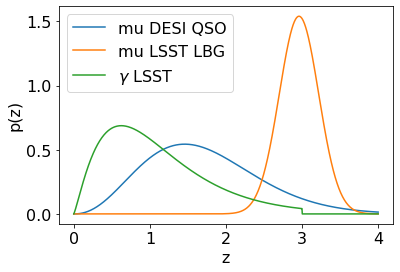

In [393]:
plt.plot(z_s, mu_qso_pdz(z_s), 'C0', label = 'mu DESI QSO')
plt.plot(z_s, mu_lbg_pdz(z_s), 'C1',  label = 'mu LSST LBG')
plt.plot(z_s, shear_pdz(z_s),  'C2', label = '$\gamma$ LSST')

plt.xlabel('z')
plt.ylabel("p(z)")
plt.legend();

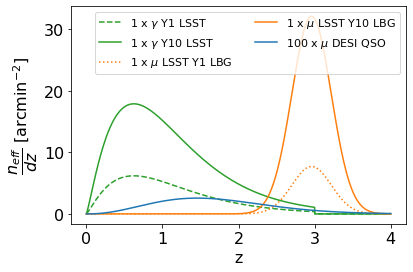

In [394]:
n1, n2, n3 = 100, 1, 1

plt.plot(z_s, n3*shear_pdz(z_s) *n_e_Y1.value,  'C2--', label = str(n3)+' x $\gamma$ Y1 LSST')
plt.plot(z_s, n3*shear_pdz(z_s) *n_e_Y10.value, 'C2', label = str(n3)+' x $\gamma$ Y10 LSST')

plt.plot(z_s, n2*mu_lbg_pdz(z_s)*n_eff_lbg_Y1.value, 'C1--', linestyle='dotted', label = str(n2)+' x $\mu$ LSST Y1 LBG')
plt.plot(z_s, n2*mu_lbg_pdz(z_s)*n_eff_lbg_Y10.value,'C1', label = str(n2)+' x $\mu$ LSST Y10 LBG')

plt.plot(z_s, n1*mu_qso_pdz(z_s)*n_eff_qso.value, 'C0', label = str(n1)+' x $\mu$ DESI QSO')

plt.xlabel('z')
plt.ylabel("$ \dfrac{n_{eff}}{dz}$ [arcmin$^{-2}$]")
plt.legend(fontsize='x-small',ncol=2);


In [395]:
print ("Source densities :\n ",\
       n_e_Y1, "for LSST shear (Y1) \n", \
       n_e_Y10, "for LSST shear (Y10) \n", \
       round(n_eff_qso.value,2)*n_eff_qso.unit, "for DESI QSO\n", \
       round(n_eff_lbg_Y1.value,2)*n_eff_lbg_Y1.unit,"for LSST LBG (Y1)\n", \
       round(n_eff_lbg_Y10.value,2)*n_eff_lbg_Y10.unit, "for LSST LBG (Y10)")

Source densities :
  9.0 1 / arcmin2 for LSST shear (Y1) 
 26.0 1 / arcmin2 for LSST shear (Y10) 
 0.05 1 / arcmin2 for DESI QSO
 5.0 1 / arcmin2 for LSST LBG (Y1)
 20.83 1 / arcmin2 for LSST LBG (Y10)


In [396]:
Ngal_s_Y1       = shear_pdz(z_s)  * (n_e_Y1 *       A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_s_Y10      = shear_pdz(z_s)  * (n_e_Y10 *       A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_qso     = mu_qso_pdz(z_s) * (n_eff_qso * A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_lbg_Y1  = mu_lbg_pdz(z_s) * (n_eff_lbg_Y1 * A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_lbg_Y10 = mu_lbg_pdz(z_s) * (n_eff_lbg_Y10 * A * (conv.to(u.arcmin/u.Mpc))**2).value

# $\frac{N_{eff}}{dz} = \frac{d n_{eff}}{dz}.A_{1Mpc}(z) $   

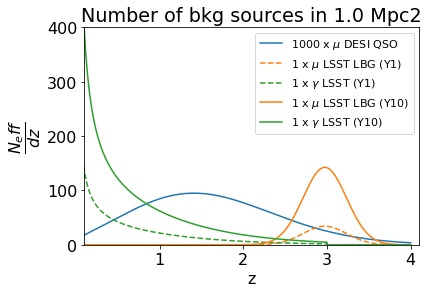

In [397]:
n1, n2, n3 = 1000, 1, 1

plt.title("Number of bkg sources in "+str(A))

plt.plot(z_s, n1*Ngal_mu_qso, 'C0',  label = str(n1)+' x $\mu$ DESI QSO')
plt.plot(z_s, n2*Ngal_mu_lbg_Y1, 'C1--', label = str(n2)+' x $\mu$ LSST LBG (Y1)')
plt.plot(z_s, n3*Ngal_s_Y1, 'C2--', label = str(n3)+' x $\gamma$ LSST (Y1)')
plt.plot(z_s, n2*Ngal_mu_lbg_Y10, 'C1', label = str(n2)+' x $\mu$ LSST LBG (Y10)')
plt.plot(z_s, n3*Ngal_s_Y10, 'C2', label = str(n3)+' x $\gamma$ LSST (Y10)')

plt.xlabel('z')
plt.ylabel("$\dfrac{N_eff}{dz}$")
plt.legend(loc="best", fontsize='x-small',ncol=1)

plt.xlim(0.1,4.1)
plt.ylim(0,400);

In [398]:
cum_Ngal_s_Y1       =  cumtrapz(Ngal_s_Y1, z_s,initial=0)
cum_Ngal_s_Y10      =  cumtrapz(Ngal_s_Y10, z_s,initial=0)
cum_Ngal_mu_qso     =  cumtrapz(Ngal_mu_qso, z_s,initial=0)
cum_Ngal_mu_lbg_Y1  =  cumtrapz(Ngal_mu_lbg_Y1, z_s,initial=0)
cum_Ngal_mu_lbg_Y10 =  cumtrapz(Ngal_mu_lbg_Y10, z_s,initial=0)

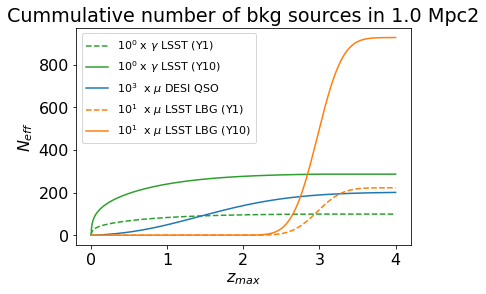

In [399]:
n1, n2, n3 = 1000, 10, 1

plt.title("Cummulative number of bkg sources in "+str(A))

plt.plot(z_s, n3* cum_Ngal_s_Y1,'C2--',       label = '10$^{' +str(round(np.log10(n3)))+ '}$ x $\gamma$ LSST (Y1)')
plt.plot(z_s, n3* cum_Ngal_s_Y10,'C2-',      label = '10$^{' +str(round(np.log10(n3)))+ '}$ x $\gamma$ LSST (Y10)')
plt.plot(z_s, n1* cum_Ngal_mu_qso,'-C0',    label = '10$^{' +str(round(np.log10(n1)))+ '}$  x $\mu$ DESI QSO')
plt.plot(z_s, n2* cum_Ngal_mu_lbg_Y1,'C1--',  label = '10$^{' +str(round(np.log10(n2)))+ '}$  x $\mu$ LSST LBG (Y1)')
plt.plot(z_s, n2* cum_Ngal_mu_lbg_Y10,'C1-', label = '10$^{' +str(round(np.log10(n2)))+ '}$  x $\mu$ LSST LBG (Y10)')

plt.xlabel('$z_{max}$')
plt.ylabel("$N_{eff}$")
plt.legend(fontsize='x-small');


# **2) Lensing strenght**

## **Shear and convergence profiles**

## $ \frac{|\gamma_\inf|}{\kappa_{inf}} = \frac{\Delta\Sigma (R)} {\Sigma (R)}$

## **Redshift distribution**

# $\beta_s(z_s) = \frac{D_{LS}}{D_S}\frac{D_{\inf}}{D_{L,\inf}}$

In [400]:
B = np.zeros((len(z_cl), z_s.size))
Bs = np.zeros((len(z_cl), z_s.size))

for i in range(len(z_cl)):
    B[i,:] = beta(z_cl[i], z_s, cosmo.be_cosmo)
    Bs[i,:] = beta_s(z_cl[i], z_s, zinf, cosmo.be_cosmo)

# $<\beta_s(z_s)> = <\frac{D_{LS}}{D_S}>\frac{D_{\inf}}{D_{L,\inf}}$
# $<\beta(z_s)> = <\frac{D_{LS}}{D_S}> = \frac{\int_{z_{s,min}}^{z_{s,max}} n(z) \beta(z)  \mathrm{d}z}{\int_{z_{s,min}}^{z_{s,max}} n(z)  \mathrm{d}z} $

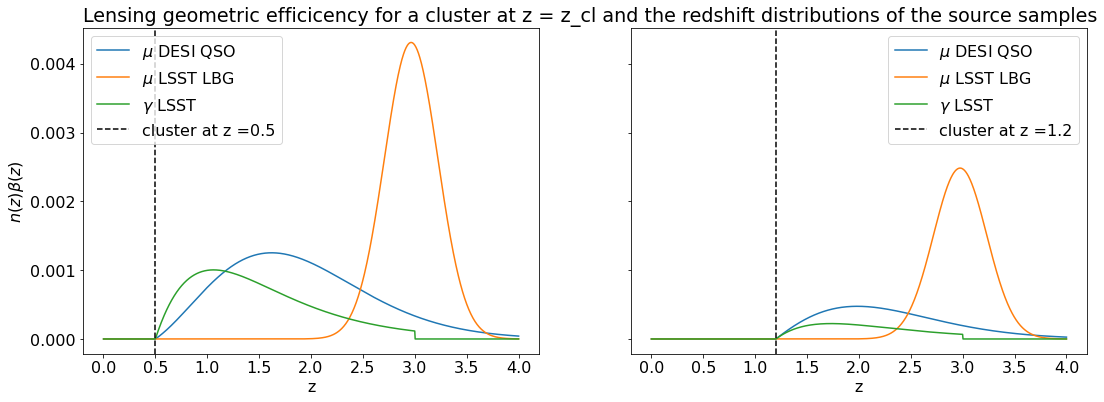

In [401]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=True, sharey=True)


ax1.set_title('Lensing geometric efficicency for a cluster at z = z_cl and the redshift distributions of the source samples', loc='left')

i = 2
ax1.plot(z_s, B[i,:] * mu_qso_pdz(z_s)/np.sum(mu_qso_pdz(z_s)), label = '$\mu$ DESI QSO')
ax1.plot(z_s, B[i,:] * mu_lbg_pdz(z_s)/np.sum(mu_lbg_pdz(z_s)), label = '$\mu$ LSST LBG')
ax1.plot(z_s, B[i,:] * shear_pdz(z_s)/np.sum(shear_pdz(z_s)), label = '$\gamma$ LSST')
ax1.axvline(z_cl[i], color='black',linestyle="dashed", label = 'cluster at z ='+str(z_cl[i]))

ax1.set_ylabel("$n(z) \\beta(z)$")
ax1.set_xlabel('z')
ax1.legend();

i = 5
ax2.plot(z_s, B[i,:] * mu_qso_pdz(z_s)/np.sum(mu_qso_pdz(z_s)), label = '$\mu$ DESI QSO')
ax2.plot(z_s, B[i,:] * mu_lbg_pdz(z_s)/np.sum(mu_lbg_pdz(z_s)), label = '$\mu$ LSST LBG')
ax2.plot(z_s, B[i,:] * shear_pdz(z_s)/np.sum(shear_pdz(z_s)), label = '$\gamma$ LSST')
ax2.axvline(z_cl[i], color='black',linestyle="dashed", label = 'cluster at z ='+str(z_cl[i]))


ax2.set_xlabel('z')
ax2.legend();

In [402]:
B_mean = np.zeros((3, len(z_cl)))
B2_mean = np.zeros((3, len(z_cl)))
Bs_mean = np.zeros((3, len(z_cl)))

pdz = [ shear_pdz,  mu_lbg_pdz, mu_qso_pdz]

for i in range(len(z_cl)):

    B_mean[0, i] = compute_B_mean(z_cl[i], pdz[0], cosmo.be_cosmo)
    B_mean[1, i] = compute_B_mean(z_cl[i], pdz[1], cosmo.be_cosmo)
    B_mean[2, i] = compute_B_mean(z_cl[i], pdz[2], cosmo.be_cosmo)
    
    Bs_mean[0, i] = B_mean[0, i] / beta(z_cl[i],zinf,cosmo.be_cosmo)
    Bs_mean[1, i] = B_mean[1, i] / beta(z_cl[i],zinf,cosmo.be_cosmo)
    Bs_mean[2, i] = B_mean[2, i] / beta(z_cl[i],zinf,cosmo.be_cosmo)
    
    B2_mean[0, i] = np.sum( B[i,:]**2 * pdz[0](z_s)) / np.sum(pdz[0](z_s))
    B2_mean[1, i] = np.sum( B[i,:]**2 * pdz[1](z_s)) / np.sum(pdz[1](z_s))
    B2_mean[2, i] = np.sum( B[i,:]**2 * pdz[2](z_s)) / np.sum(pdz[2](z_s))    
    
B_mean_shear, B_mean_mu_LBG, B_mean_mu_qso = B_mean
Bs_mean_shear, Bs_mean_mu_LBG, Bs_mean_mu_qso = Bs_mean
B2_mean_shear, B2_mean_mu_LBG, B2_mean_mu_qso, = B2_mean

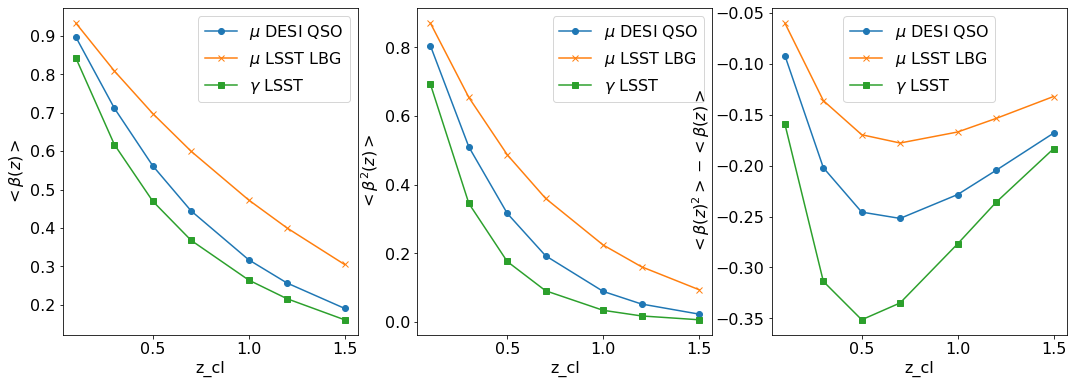

In [403]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(18,6), sharex=True)

ax1.plot(z_cl, B_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
ax1.plot(z_cl, B_mean_mu_LBG, 'x-', label = '$\mu$ LSST LBG')
ax1.plot(z_cl, B_mean_shear, 's-',  label = '$\gamma$ LSST')

ax1.set_ylabel("$<\\beta(z)>$")
ax1.set_xlabel('z_cl')
ax1.legend();

ax2.plot(z_cl, B2_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
ax2.plot(z_cl, B2_mean_mu_LBG, 'x-', label = '$\mu$ LSST LBG')
ax2.plot(z_cl, B2_mean_shear, 's-',  label = '$\gamma$ LSST')

ax2.set_ylabel("$<\\beta^2(z)>$")
ax2.set_xlabel('z_cl')
ax2.legend();

#Eq.12 in https://arxiv.org/pdf/1611.03866.pdf and Eq.6 and note in https://academic.oup.com/mnras/article/439/1/48/963939
ax3.plot(z_cl, (B2_mean_mu_qso/B_mean_mu_qso -1)*B_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
ax3.plot(z_cl, (B2_mean_mu_LBG/B_mean_mu_LBG -1)*B_mean_mu_qso, 'x-', label = '$\mu$ LSST LBG')
ax3.plot(z_cl, (B2_mean_shear/B_mean_shear -1)*B_mean_mu_qso, 's-',  label = '$\gamma$ LSST')

ax3.set_ylabel("$<\\beta(z)^2> - <\\beta(z)> $")
ax3.set_xlabel('z_cl')
ax3.legend();

### The corrections of the form $<\beta(z)^2> - <\beta(z)> $ are negligeable. Thus we use $<g> \approx <\gamma> \approx <\beta_s>\gamma_{inf}$

# **Plots for publication**

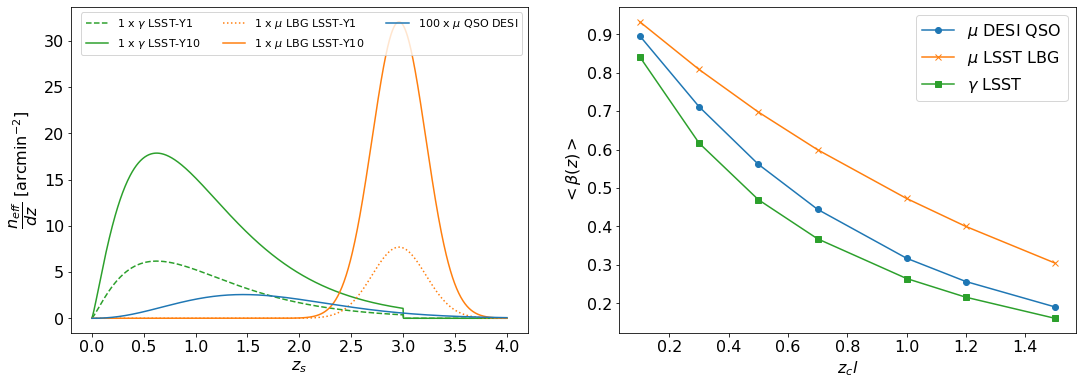

In [404]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=False)


n1, n2, n3 = 100, 1, 1

ax1.plot(z_s, n3*shear_pdz(z_s) *n_e_Y1.value,  'C2--', label = str(n3)+' x $\gamma$ LSST-Y1')
ax1.plot(z_s, n3*shear_pdz(z_s) *n_e_Y10.value, 'C2', label = str(n3)+' x $\gamma$ LSST-Y10')

ax1.plot(z_s, n2*mu_lbg_pdz(z_s)*n_eff_lbg_Y1.value, 'C1--', linestyle='dotted', label = str(n2)+' x $\mu$ LBG LSST-Y1')
ax1.plot(z_s, n2*mu_lbg_pdz(z_s)*n_eff_lbg_Y10.value,'C1', label = str(n2)+' x $\mu$ LBG LSST-Y10')

ax1.plot(z_s, n1*mu_qso_pdz(z_s)*n_eff_qso.value, 'C0', label = str(n1)+' x $\mu$ QSO DESI')

ax1.set_xlabel('$z_s$')
ax1.set_ylabel("$ \dfrac{n_{eff}}{dz}$ [arcmin$^{-2}$]")
ax1.legend(fontsize='x-small',ncol=3);




ax2.plot(z_cl, B_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
ax2.plot(z_cl, B_mean_mu_LBG, 'x-', label = '$\mu$ LSST LBG')
ax2.plot(z_cl, B_mean_shear, 's-',  label = '$\gamma$ LSST')


ax2.set_ylabel("$<\\beta(z)>$")
ax2.set_xlabel('$z_cl$')
ax2.legend();